<a href="https://colab.research.google.com/github/mgfrantz/CTME-llm-lecture-resources/blob/main/rag_and_agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agents and RAG

In this lab, we're going to create a customer service bot.
We will use LLM fundamentals and create modules in a step-by-step approach and by the end of the day we'll have a basic customer service chatbot.

# Setup

In this lab, we'll be using Gemini.
First, let's make sure you have a Gemini API key.
Navigate to [Google AI Studio](https://aistudio.google.com/) and create an API key.
Don't worry, we are just using the free tier for this lab.

Once you've created your API key, please add it to the secrets tab to the left 👈 as shown below.
Then, you can run this group of cells for setup.

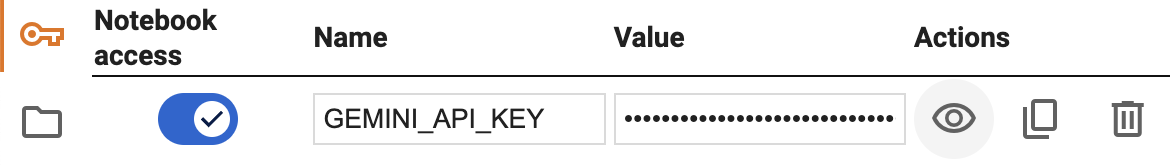


This setup also sets up a SQLite database with several tables we wil use.

In [4]:
# Installs
!pip install -qqqq \
    litellm \
    llama-index \
    llama-index-llms-gemini \
    sqlite-vec \
    sqlite-lembed \
    --progress-bar off

In [5]:
# Environment variables
from google.colab import userdata
import os
os.environ['GEMINI_API_KEY'] = userdata.get('GEMINI_API_KEY')

In [13]:
# Database setup
import sqlite3
import sqlite_vec
import sqlite_lembed
import pandas as pd
import os

# Remove existing database if it exists to start fresh
if os.path.exists('ecommerce.db'):
    os.remove('ecommerce.db')

# Sample data for each table

# Customers Data
customers_data = [
    ('C1001', 'John Doe', 'john.doe@example.com', '555-1234', '123 Elm Street', 'active', '1234'),
    ('C1002', 'Jane Smith', 'jane.smith@example.com', '555-5678', '456 Oak Avenue', 'active', '0097'),
    ('C1003', 'Bob Johnson', 'bob.johnson@example.com', '555-9012', '789 Pine Road', 'suspended', '5432'),
]

# Define the DataFrame with matching column names
customers_df = pd.DataFrame(customers_data, columns=['customerId', 'name', 'email', 'phone', 'address', 'accountStatus', 'pin'])

# Items Data
items_data = [
    ('I5001', 'Wireless Mouse', 'Ergonomic wireless mouse with adjustable DPI', 25.99),
    ('I5002', 'Mechanical Keyboard', 'RGB backlit mechanical keyboard with blue switches', 89.99),
    ('I5003', 'HD Monitor', '24-inch HD monitor with 1080p resolution', 149.99),
    ('I5004', 'Gaming Headset', 'Surround sound gaming headset with noise-cancelling microphone', 59.99)
]

# Define the DataFrame with matching column names
items_df = pd.DataFrame(items_data, columns=['itemId', 'name', 'description', 'price'])

# Orders Data
orders_data = [
    ('O3001', 'C1001', 'I5001', 'processing', '2024-09-20', '2024-10-05', 'FastShip', 'FS123456789', '123 Elm Street'),
    ('O3002', 'C1002', 'I5002', 'shipped', '2024-09-22', '2024-10-07', 'QuickDelivery', 'QD987654321', '456 Oak Avenue'),
    ('O3003', 'C1001', 'I5003', 'delivered', '2024-09-25', '2024-09-30', 'FastShip', 'FS112233445', '123 Elm Street'),
    ('O3004', 'C1003', 'I5004', 'refunded', '2024-09-26', '2024-10-10', 'FastShip', 'FS998877665', '789 Pine Road')
]

# Define the DataFrame with matching column names
orders_df = pd.DataFrame(orders_data, columns=[
    'orderId',
    'customerId',
    'itemId',
    'status',
    'orderedDate',
    'estimatedDelivery',
    'shippingCarrier',
    'trackingNumber',
    'shippingAddress'
])

def create_tables(conn):
    cursor = conn.cursor()

    # Enable foreign key support
    cursor.execute("PRAGMA foreign_keys = ON;")

    # Create Customers Table
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS customers (
            customerId TEXT PRIMARY KEY,
            name TEXT NOT NULL,
            email TEXT UNIQUE NOT NULL,
            phone TEXT,
            address TEXT,
            accountStatus TEXT,
            pin TEXT
        );
    """)

    # Create Items Table
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS items (
            itemId TEXT PRIMARY KEY,
            name TEXT NOT NULL,
            description TEXT,
            price REAL NOT NULL
        );
    """)

    # Create Orders Table
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS orders (
            orderId TEXT PRIMARY KEY,
            customerId TEXT NOT NULL,
            itemId TEXT NOT NULL,
            status TEXT,
            orderedDate TEXT,
            estimatedDelivery TEXT,
            shippingCarrier TEXT,
            trackingNumber TEXT,
            shippingAddress TEXT,
            FOREIGN KEY (customerId) REFERENCES Customers(customerId),
            FOREIGN KEY (itemId) REFERENCES Items(itemId)
        );
    """)

    conn.commit()
    print("Tables created successfully.")

def insert_data(conn, df, table_name):
    try:
        df.to_sql(table_name, conn, if_exists='append', index=False)
        print(f"Data inserted successfully into '{table_name}' table.")
    except Exception as e:
        print(f"Error inserting data into '{table_name}': {e}")

def setup_vectorstore(conn):
    print("Downloading nomic-embed-text-v1.5.Q8_0.gguf to nomic.gguf")
    !curl -L -o nomic.gguf https://huggingface.co/nomic-ai/nomic-embed-text-v1.5-GGUF/blob/main/nomic-embed-text-v1.5.Q8_0.gguf
    conn.enable_load_extension(True)
    sqlite_vec.load(conn)
    sqlite_lembed.load(conn)
    conn.enable_load_extension(False)

    vec_version, = conn.execute("select vec_version()").fetchone()
    print(f"Vector store and embeddings enabled. vec_version={vec_version}")

    print('Registering embedding model...')
    add_embed_fn_qry = """\
INSERT INTO temp.lembed_models(name, model)
    select 'nomic', lembed_model_from_file('/content/nomic.gguf');
"""
    conn.execute(add_embed_fn_qry)

    print("embedding 'hello world!'..., ", conn.execute("SELECT lembed('nomic', 'hello world!')").fetchone())

def setup_db():
    # Connect to SQLite database (it will be created if it doesn't exist)
    conn = sqlite3.connect('ecommerce.db')
    print("Connected to SQLite database 'ecommerce.db'.")

    try:
        create_tables(conn)
        # Insert data in the correct order to satisfy foreign key constraints
        insert_data(conn, customers_df, 'customers')
        insert_data(conn, items_df, 'items')
        insert_data(conn, orders_df, 'orders')
        setup_vectorstore(conn)

    except sqlite3.IntegrityError as e:
        print(f"An integrity error occurred: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        conn.close()
        print("SQLite connection closed.")

setup_db()

Connected to SQLite database 'ecommerce.db'.
Tables created successfully.
Data inserted successfully into 'customers' table.
Data inserted successfully into 'items' table.
Data inserted successfully into 'orders' table.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51131  100 51131    0     0   369k      0 --:--:-- --:--:-- --:--:--  369k
Vector store and embeddings enabled. vec_version=v0.1.3
Registering embedding model...
An error occurred: SQL logic error
SQLite connection closed.


# Utility functions

This section just defines several SQL utilities such as the `query` and `execute` functions to interact with the SQL database.

Here's the signature for the `query` function:

```python
def query(q:str, db:str='ecommerce.db') -> pd.DataFrame:
    """
    Executes a SQL query against the SQLite database and returns the result as a pandas DataFrame.
    Use this function when you want to query a database and return results.

    Args:
        q (str): The SQL query to execute.
        db (str, optional): The path to the SQLite database file. Defaults to 'ecommerce.db'.

    Returns:
        pd.DataFrame: The result of the SQL query as a pandas DataFrame.
    """
...
```

And here's the signature for the `execute` function:

```python
def execute(q:str, db:str='ecommerce.db') -> None:
    """
    Executes an SQL query against the SQLite database.
    Use this when you want to run commands like updates, inserts, or deletes that don't return results.

    Args:
        q (str): The SQL query to execute.
        db (str, optional): The path to the SQLite database file. Defaults to 'ecommerce.db'.

    Returns:
        None
    """
...
```

In [97]:
import sqlite3
import pandas as pd
from IPython.display import display

In [98]:
def query(q:str, db:str='ecommerce.db') -> pd.DataFrame:
    """
    Executes a SQL query against the SQLite database and returns the result as a pandas DataFrame.
    Use this function when you want to query a database and return results.

    Args:
        q (str): The SQL query to execute.
        db (str, optional): The path to the SQLite database file. Defaults to 'ecommerce.db'.

    Returns:
        pd.DataFrame: The result of the SQL query as a pandas DataFrame.
    """
    connection = sqlite3.connect(db)
    cursor = connection.cursor()
    cursor.execute(q)
    result = cursor.fetchall()
    df = pd.DataFrame(result)
    df.columns = [i[0] for i in cursor.description]
    connection.close()
    return df

def execute(q:str, db:str='ecommerce.db') -> None:
    """
    Executes an SQL query against the SQLite database.
    Use this when you want to run commands like updates, inserts, or deletes that don't return results.

    Args:
        q (str): The SQL query to execute.
        db (str, optional): The path to the SQLite database file. Defaults to 'ecommerce.db'.

    Returns:
        None
    """
    connection = sqlite3.connect(db)
    cursor = connection.cursor()
    cursor.execute(q)
    connection.commit()
    connection.close()

In [99]:
for table in ['customers', 'items', 'orders']:
    print(f'Table: {table}')
    display(query(f'SELECT * FROM {table}'))

Table: customers


,customerId,name,email,phone,address,accountStatus,pin
0,C1001,John Doe,john.doe@example.com,555-1234,123 Elm Street,active,1234
1,C1002,Jane Smith,jane.smith@example.com,555-5678,456 Oak Avenue,active,0097
2,C1003,Bob Johnson,bob.johnson@example.com,555-9012,789 Pine Road,suspended,5432


Table: items


,itemId,name,description,price
0,I5001,Wireless Mouse,Ergonomic wireless mouse with adjustable DPI,25.99
1,I5002,Mechanical Keyboard,RGB backlit mechanical keyboard with blue swit...,89.99
2,I5003,HD Monitor,24-inch HD monitor with 1080p resolution,149.99
3,I5004,Gaming Headset,Surround sound gaming headset with noise-cance...,59.99


Table: orders


,orderId,customerId,itemId,status,orderedDate,estimatedDelivery,shippingCarrier,trackingNumber,shippingAddress
0,O3001,C1001,I5001,processing,2024-09-20,2024-10-05,FastShip,FS123456789,123 Elm Street
1,O3002,C1002,I5002,shipped,2024-09-22,2024-10-07,QuickDelivery,QD987654321,456 Oak Avenue
2,O3003,C1001,I5003,delivered,2024-09-25,2024-09-30,FastShip,FS112233445,123 Elm Street
3,O3004,C1003,I5004,refunded,2024-09-26,2024-10-10,FastShip,FS998877665,789 Pine Road


# Problem statement

We are building a chatbot to automate simple customer interactions.
Let's consider the following flow:

[INSERT IMAGE HERE]

We have a basic branching tree of actions we want to take.
We will build them individually, then compose them into a full workflow.
Here are the actions we will support:

- Update customer info (requires authentication)
  - Update email
  - Update phone number
  - Update address
  - Change pin
  - Close account
- Order information (requires authentication)
    - Check order information
    - Cancel order (make sure to refer to cancellation/return policy)
- Ask question about a product

# Greet customer

# Select action

# Customer Info Agent

# Order Agent

# Product Agent

# Customer Service Agent